In [125]:
%pip install mne


Note: you may need to restart the kernel to use updated packages.



[notice] A new release of pip is available: 25.3 -> 26.0.1
[notice] To update, run: python.exe -m pip install --upgrade pip


In [126]:
import mne
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd


In [127]:
DATA_DIR = "eeg-during-mental-arithmetic-tasks-1.0.0"
FILE = f"{DATA_DIR}/Subject00_1.edf"   # condition 1

raw = mne.io.read_raw_edf(FILE, preload=True, verbose=False)


In [128]:
raw.info


<Info | 8 non-empty values
 bads: []
 ch_names: EEG Fp1, EEG Fp2, EEG F3, EEG F4, EEG F7, EEG F8, EEG T3, EEG ...
 chs: 21 EEG
 custom_ref_applied: False
 highpass: 0.5 Hz
 lowpass: 45.0 Hz
 meas_date: 2011-01-01 00:00:00 UTC
 nchan: 21
 projs: []
 sfreq: 500.0 Hz
 subject_info: <subject_info | his_id: 0, sex: 1, last_name: Subject0, birthday: 1990-01-01>
>

In [129]:
raw.ch_names


['EEG Fp1',
 'EEG Fp2',
 'EEG F3',
 'EEG F4',
 'EEG F7',
 'EEG F8',
 'EEG T3',
 'EEG T4',
 'EEG C3',
 'EEG C4',
 'EEG T5',
 'EEG T6',
 'EEG P3',
 'EEG P4',
 'EEG O1',
 'EEG O2',
 'EEG Fz',
 'EEG Cz',
 'EEG Pz',
 'EEG A2-A1',
 'ECG ECG']

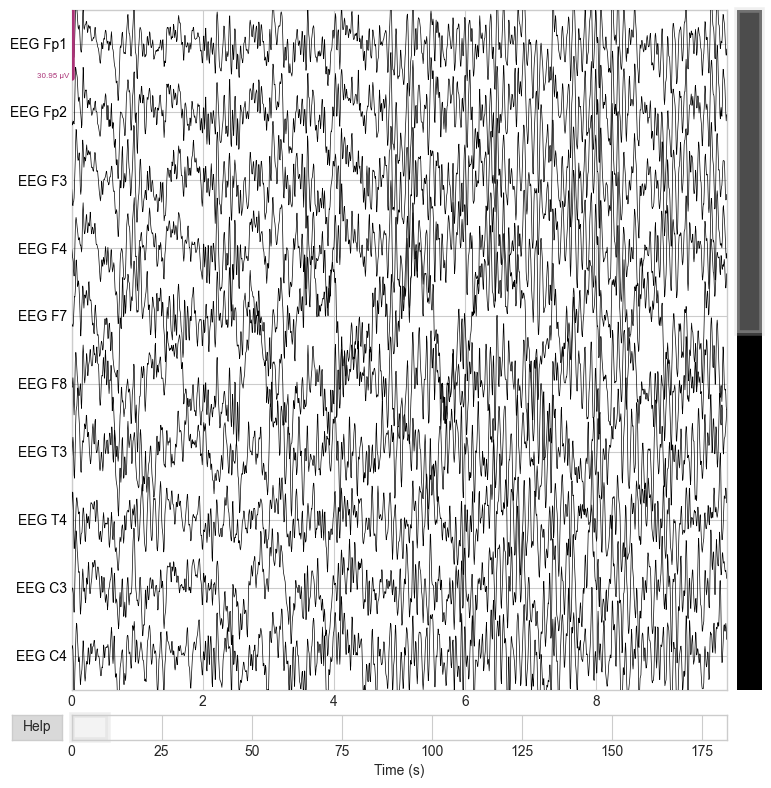

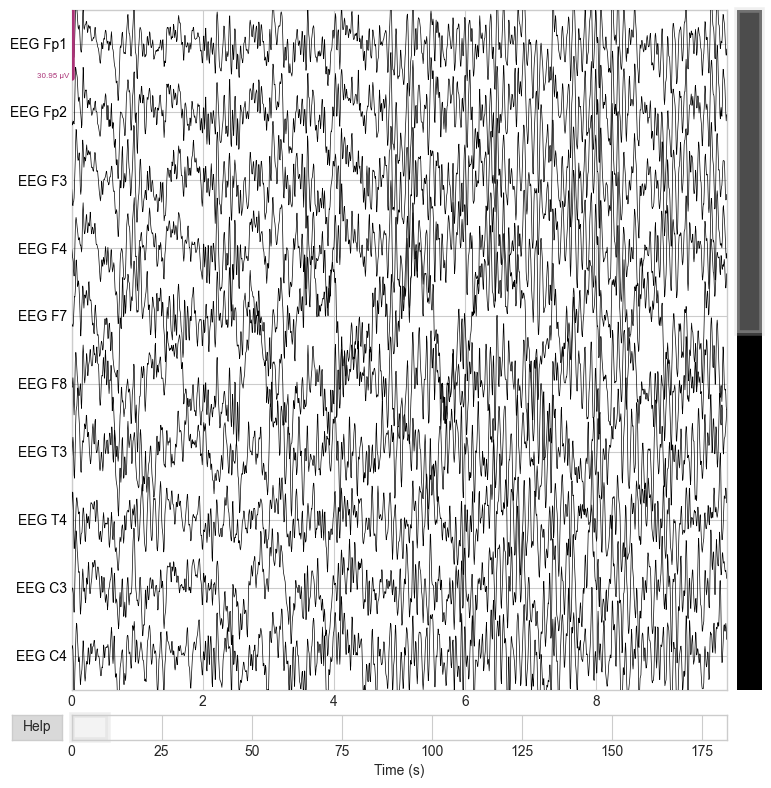

In [130]:
raw.plot(
    n_channels=10,
    scalings="auto",
    duration=10,
    start=0
)


In [131]:
data = raw.get_data()      # shape: (channels, samples)
sfreq = raw.info['sfreq']

print(data.shape)
print("Sampling frequency:", sfreq)


(21, 91000)
Sampling frequency: 500.0


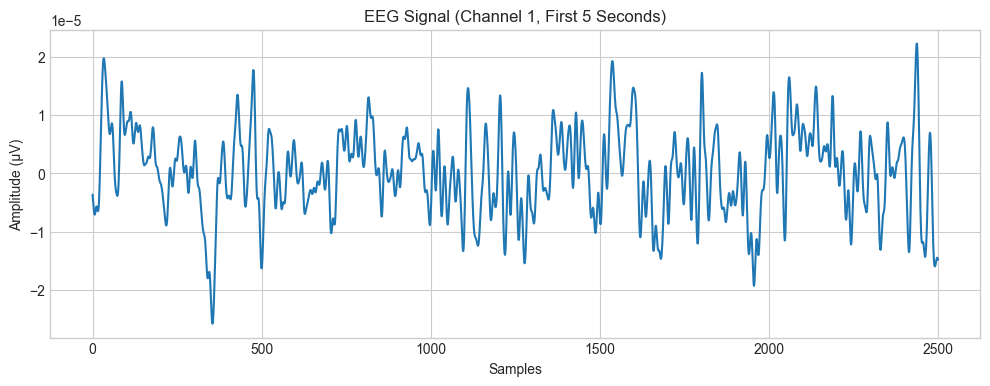

In [132]:
channel_idx = 0   # first channel
samples = int(sfreq * 5)  # first 5 seconds

plt.figure(figsize=(12,4))
plt.plot(data[channel_idx, :samples])
plt.xlabel("Samples")
plt.ylabel("Amplitude (µV)")
plt.title("EEG Signal (Channel 1, First 5 Seconds)")
plt.grid(True)
plt.show()


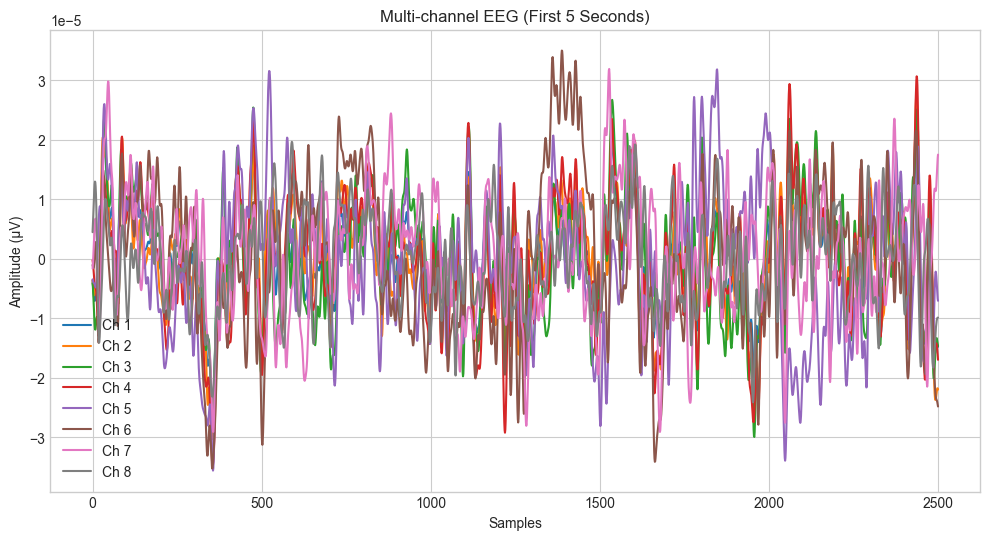

In [133]:
plt.figure(figsize=(12,6))
for ch in range(min(8, data.shape[0])):
    plt.plot(data[ch, :samples], label=f"Ch {ch+1}")

plt.xlabel("Samples")
plt.ylabel("Amplitude (µV)")
plt.title("Multi-channel EEG (First 5 Seconds)")
plt.legend()
plt.grid(True)
plt.show()


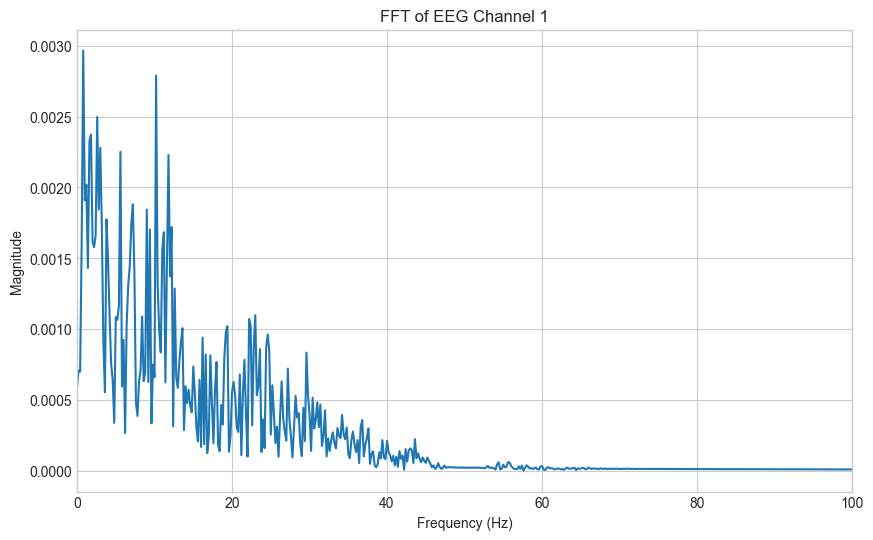

In [134]:
signal = data[channel_idx, :samples]
N = len(signal)

fft_vals = np.fft.fft(signal)
fft_mag = np.abs(fft_vals)[:N//2]
freqs = np.fft.fftfreq(N, d=1/sfreq)[:N//2]
plt.figure(figsize=(10,6))
plt.plot(freqs, fft_mag)
plt.xlim(0, 100)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Magnitude")
plt.title("FFT of EEG Channel 1")
plt.grid(True)
plt.show()


Effective window size : 2.048 (s)


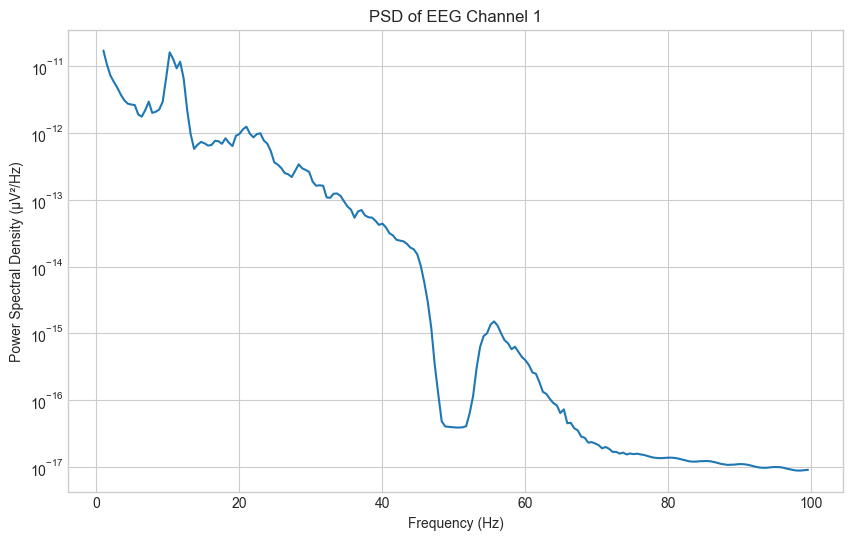

In [135]:
psds, freqs = mne.time_frequency.psd_array_welch(
    data[channel_idx],
    sfreq=sfreq,
    fmin=0.5,
    fmax=100,
    n_fft=1024
)
plt.figure(figsize=(10,6))
plt.semilogy(freqs, psds)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density (µV²/Hz)")
plt.title("PSD of EEG Channel 1")
plt.grid(True)
plt.show()



In [136]:
raw_1 = mne.io.read_raw_edf(f"{DATA_DIR}/Subject00_1.edf", preload=True, verbose=False)
raw_2 = mne.io.read_raw_edf(f"{DATA_DIR}/Subject00_2.edf", preload=True, verbose=False)

raw_1.filter(1, 40)
raw_2.filter(1, 40)

data_1 = raw_1.get_data()
data_2 = raw_2.get_data()


Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 40.00 Hz
- Upper transition bandwidth: 10.00 Hz (-6 dB cutoff frequency: 45.00 Hz)
- Filter length: 1651 samples (3.302 s)

Filtering raw data in 1 contiguous segment
Setting up band-pass filter from 1 - 40 Hz

FIR filter parameters
---------------------
Designing a one-pass, zero-phase, non-causal bandpass filter:
- Windowed time-domain design (firwin) method
- Hamming window with 0.0194 passband ripple and 53 dB stopband attenuation
- Lower passband edge: 1.00
- Lower transition bandwidth: 1.00 Hz (-6 dB cutoff frequency: 0.50 Hz)
- Upper passband edge: 

Effective window size : 0.512 (s)
Effective window size : 0.512 (s)


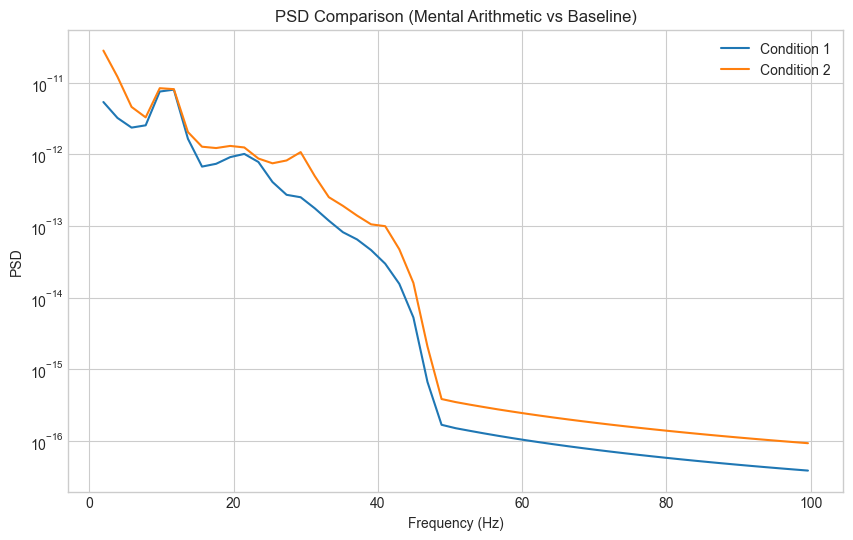

In [137]:
psd_1, freqs = mne.time_frequency.psd_array_welch(data_1[channel_idx], sfreq, fmin=0.5, fmax=100)
psd_2, _     = mne.time_frequency.psd_array_welch(data_2[channel_idx], sfreq, fmin=0.5, fmax=100)

plt.figure(figsize=(10,6))
plt.semilogy(freqs, psd_1, label="Condition 1")
plt.semilogy(freqs, psd_2, label="Condition 2")
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD")
plt.title("PSD Comparison (Mental Arithmetic vs Baseline)")
plt.legend()
plt.grid(True)
plt.show()


In [138]:
bands = {
    "Delta": (0.5, 4),
    "Theta": (4, 8),
    "Alpha": (8, 13),
    "Beta":  (13, 30)
}


In [139]:
channel_idx = 0  # same channel for fair comparison

psd_1, freqs = mne.time_frequency.psd_array_welch(
    data_1[channel_idx],
    sfreq=sfreq,
    fmin=0.5,
    fmax=40,
    n_fft=2048
)

psd_2, _ = mne.time_frequency.psd_array_welch(
    data_2[channel_idx],
    sfreq=sfreq,
    fmin=0.5,
    fmax=40,
    n_fft=2048
)


Effective window size : 4.096 (s)
Effective window size : 4.096 (s)


In [140]:
def band_power(psd, freqs, fmin, fmax):
    idx = (freqs >= fmin) & (freqs <= fmax)
    return np.mean(psd[idx])
band_powers_1 = {}
band_powers_2 = {}

for band, (fmin, fmax) in bands.items():
    band_powers_1[band] = band_power(psd_1, freqs, fmin, fmax)
    band_powers_2[band] = band_power(psd_2, freqs, fmin, fmax)



In [141]:
import pandas as pd

df_band_power = pd.DataFrame({
    "Baseline": band_powers_1,
    "Mental Arithmetic": band_powers_2
})

df_band_power


,Baseline,Mental Arithmetic
Delta,6.732128e-12,4.115422e-11
Theta,2.284026e-12,3.962749e-12
Alpha,7.121478e-12,7.418800e-12
Beta,6.664485e-13,1.163518e-12


In [142]:
theta_alpha_1 = band_powers_1["Theta"] / band_powers_1["Alpha"]
theta_alpha_2 = band_powers_2["Theta"] / band_powers_2["Alpha"]

theta_alpha_1, theta_alpha_2


(0.3207235858589456, 0.5341495815102579)

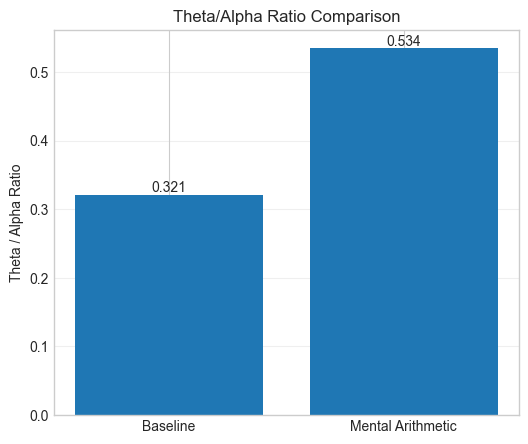

In [143]:
import matplotlib.pyplot as plt

# Values
conditions = ['Baseline', 'Mental Arithmetic']
theta_alpha_values = [0.3207235858589456, 0.5341495815102579]

# Plot
plt.figure(figsize=(6,5))
bars = plt.bar(conditions, theta_alpha_values)

plt.ylabel('Theta / Alpha Ratio')
plt.title('Theta/Alpha Ratio Comparison')

# Add value labels on top of bars
for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2, height,
             f'{height:.3f}', ha='center', va='bottom')

plt.grid(axis='y', alpha=0.3)
plt.show()


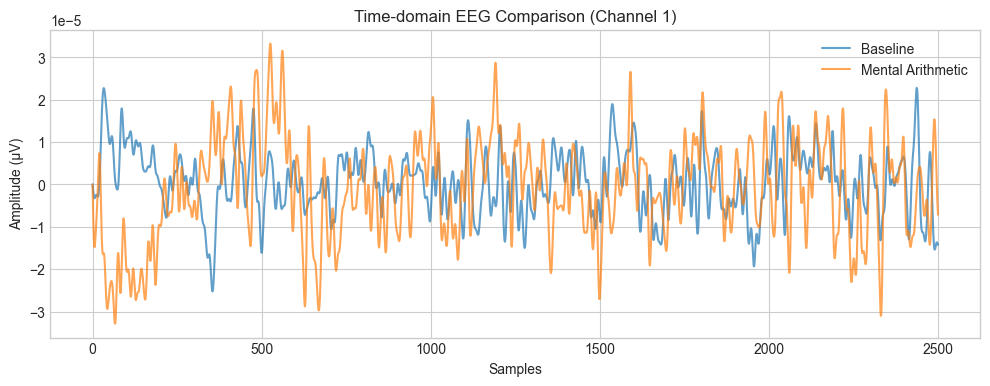

In [144]:
samples = int(sfreq * 5)  # first 5 seconds

plt.figure(figsize=(12,4))
plt.plot(data_1[channel_idx, :samples], label='Baseline', alpha=0.7)
plt.plot(data_2[channel_idx, :samples], label='Mental Arithmetic', alpha=0.7)
plt.xlabel('Samples')
plt.ylabel('Amplitude (µV)')
plt.title('Time-domain EEG Comparison (Channel 1)')
plt.legend()
plt.grid(True)
plt.show()


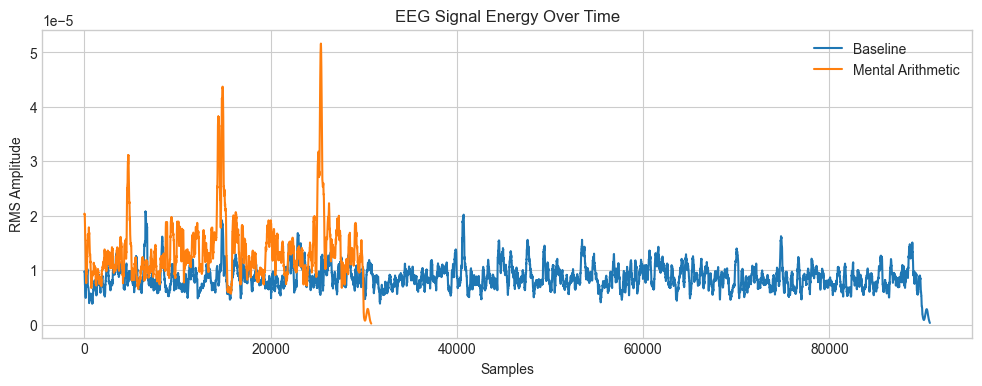

In [145]:
def rms(signal, window=200):
    return np.sqrt(np.convolve(signal**2, np.ones(window)/window, mode='valid'))

plt.figure(figsize=(12,4))
plt.plot(rms(data_1[channel_idx], 200), label='Baseline')
plt.plot(rms(data_2[channel_idx], 200), label='Mental Arithmetic')
plt.xlabel('Samples')
plt.ylabel('RMS Amplitude')
plt.title('EEG Signal Energy Over Time')
plt.legend()
plt.grid(True)
plt.show()


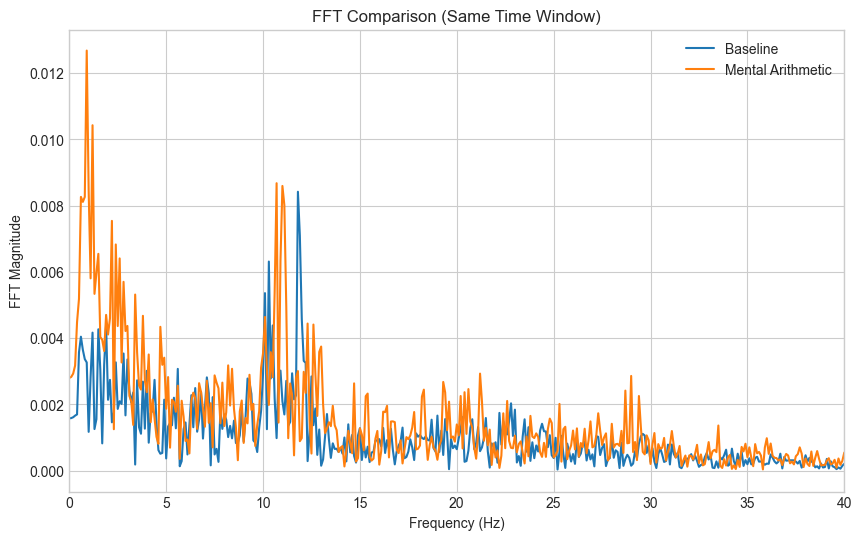

In [146]:
# Use the SAME number of samples for both conditions
samples = int(sfreq * 10)  # first 10 seconds

sig1 = data_1[channel_idx, :samples]
sig2 = data_2[channel_idx, :samples]

def compute_fft(signal, sfreq):
    N = len(signal)
    fft_vals = np.abs(np.fft.fft(signal))[:N//2]
    freqs = np.fft.fftfreq(N, d=1/sfreq)[:N//2]
    return freqs, fft_vals

freqs, fft1 = compute_fft(sig1, sfreq)
_, fft2 = compute_fft(sig2, sfreq)
plt.figure(figsize=(10,6))
plt.plot(freqs, fft1, label='Baseline')
plt.plot(freqs, fft2, label='Mental Arithmetic')
plt.xlim(0, 40)
plt.xlabel('Frequency (Hz)')
plt.ylabel('FFT Magnitude')
plt.title('FFT Comparison (Same Time Window)')
plt.legend()
plt.grid(True)
plt.show()


Effective window size : 4.096 (s)
Effective window size : 4.096 (s)


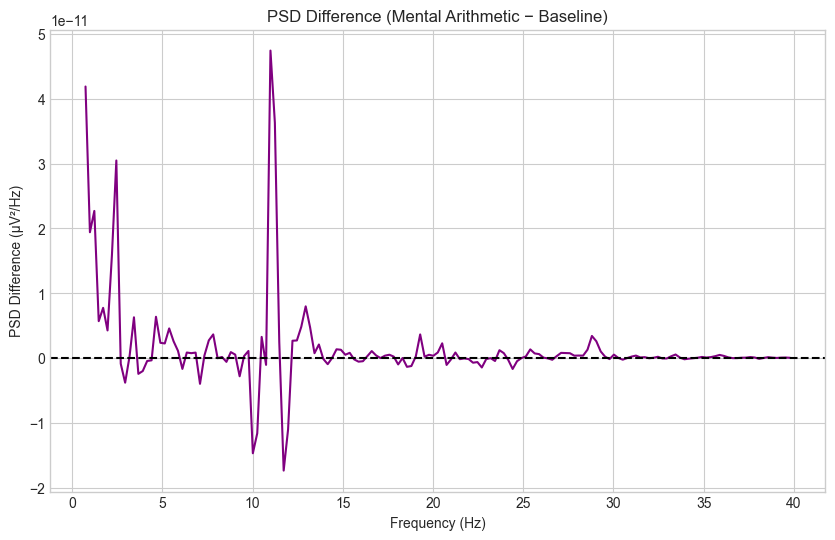

In [147]:
channel_idx = 0
samples = int(sfreq * 10)
# Extract equal-length segments
sig_baseline = data_1[channel_idx, :samples]
sig_task     = data_2[channel_idx, :samples]

psd_base, freqs = mne.time_frequency.psd_array_welch(
    sig_baseline, sfreq=sfreq, fmin=0.5, fmax=40, n_fft=2048
)

psd_task, _ = mne.time_frequency.psd_array_welch(
    sig_task, sfreq=sfreq, fmin=0.5, fmax=40, n_fft=2048
)

psd_diff = psd_task - psd_base
plt.figure(figsize=(10,6))
plt.plot(freqs, psd_diff, color='purple')
plt.axhline(0, color='black', linestyle='--')
plt.xlabel("Frequency (Hz)")
plt.ylabel("PSD Difference (µV²/Hz)")
plt.title("PSD Difference (Mental Arithmetic − Baseline)")
plt.grid(True)
plt.show()



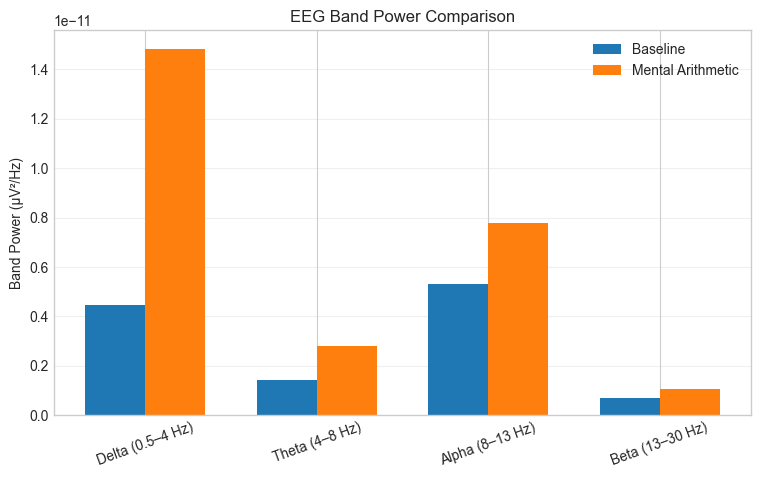

In [148]:
bands = {
    "Delta (0.5–4 Hz)": (0.5, 4),
    "Theta (4–8 Hz)": (4, 8),
    "Alpha (8–13 Hz)": (8, 13),
    "Beta (13–30 Hz)": (13, 30)
}
def band_power(psd, freqs, fmin, fmax):
    idx = (freqs >= fmin) & (freqs <= fmax)
    return np.mean(psd[idx])
bp_base = []
bp_task = []

for (fmin, fmax) in bands.values():
    bp_base.append(band_power(psd_base, freqs, fmin, fmax))
    bp_task.append(band_power(psd_task, freqs, fmin, fmax))

labels = list(bands.keys())
x = np.arange(len(labels))
width = 0.35

plt.figure(figsize=(9,5))
plt.bar(x - width/2, bp_base, width, label='Baseline')
plt.bar(x + width/2, bp_task, width, label='Mental Arithmetic')

plt.xticks(x, labels, rotation=20)
plt.ylabel("Band Power (µV²/Hz)")
plt.title("EEG Band Power Comparison")
plt.legend()
plt.grid(axis='y', alpha=0.3)
plt.show()



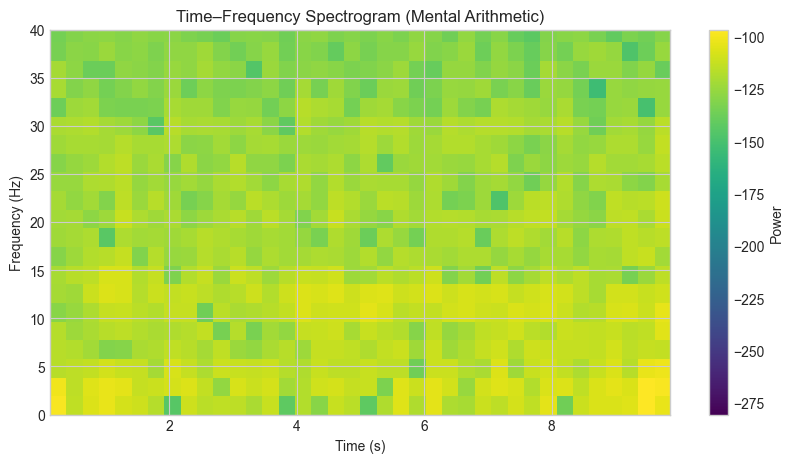

In [149]:
plt.figure(figsize=(10,5))
plt.specgram(
    sig_task,
    Fs=sfreq,
    NFFT=256,
    noverlap=128,
    cmap='viridis'
)
plt.xlabel("Time (s)")
plt.ylabel("Frequency (Hz)")
plt.title("Time–Frequency Spectrogram (Mental Arithmetic)")
plt.colorbar(label="Power")
plt.ylim(0, 40)
plt.show()


Massive Low-Frequency Drift (The "Wander"):Evidence: In Image 2 (Time Domain), the blue line wanders up and down significantly over 5 seconds. In Image 4 (PSD), the highest power is at the far left (<1Hz>).Impact: This drift inflates your "Delta" band power artificially. It makes it look like there is brain activity when it is likely just sweat or electrode settling.

Eye Blink Artifacts (The "Spikes"):

Evidence: In Image 8 (RMS Energy), the orange line (Mental Arithmetic) has massive spikes where energy jumps 3x–5x. In Image 10 (Band Power), the "Delta" bar for Mental Arithmetic is huge.

Impact: Since you are using frontal channels (Fp1, Fp2), these channels sit directly over the forehead muscles and eyes. When the subject blinks (which happens more during stressful mental math), it creates a huge electrical spike that mimics Delta waves. You must clean this, or your results will be invalid.

Line Noise (50 Hz):

Evidence: In Image 4 (PSD), there is a deep "valley" or notch exactly at 50 Hz.

Insight: This suggests your recording device likely has a hardware notch filter active, or the data was pre-processed. However, applying a software notch is still a safe standard procedure.



Processing: eeg-during-mental-arithmetic-tasks-1.0.0/Subject00_2.edf
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.
   > DETECTED BLINK COMPONENT: ICA011
   > (This component has the highest variance, typical of blinks)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)


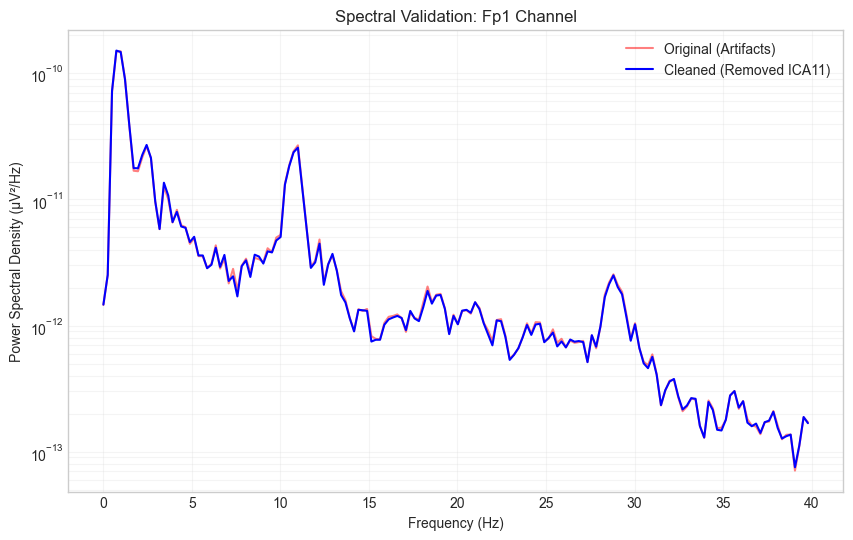

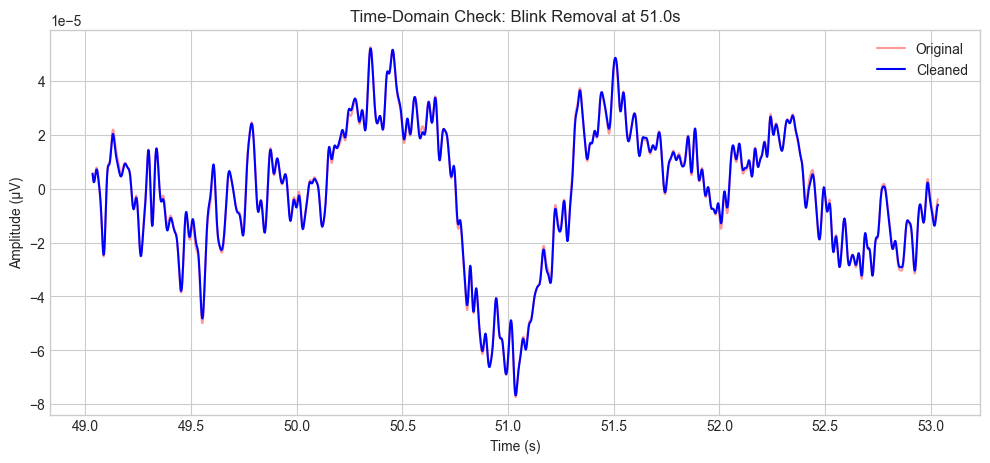

Plotting Topography of ICA011 (Should look like frontal blinks)...


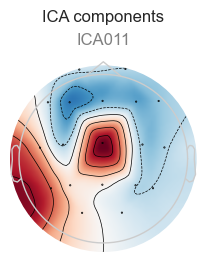

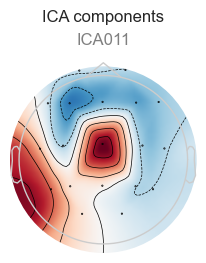

In [165]:
import mne
import numpy as np
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
DATA_DIR = "eeg-during-mental-arithmetic-tasks-1.0.0"
FILE_PATH = f"{DATA_DIR}/Subject00_2.edf" 

def robust_ica_cleaning(filepath):
    print(f"Processing: {filepath}")
    
    # 1. Load Data
    raw = mne.io.read_raw_edf(filepath, preload=True, verbose=False)
    
    # 2. CLEAN CHANNEL NAMES (Remove 'EEG ' prefix)
    mne.rename_channels(raw.info, lambda x: x.replace('EEG ', ''))
    
    # 3. FORCE DELETE BAD CHANNELS (The Fix)
    # We explicitly remove the troublemakers so they don't exist in the data anymore.
    # 'on_missing=ignore' ensures it doesn't crash if they are already gone.
    raw.drop_channels(['ECG ECG', 'A2-A1'], on_missing='ignore')
    
    # 4. Set Montage (Now safe because only standard 10-20 channels remain)
    raw.set_montage('standard_1020', on_missing='ignore')
    
    # 5. Filter (High-pass 1.0 Hz is critical for ICA)
    raw_filtered = raw.copy().filter(l_freq=1.0, h_freq=40.0, verbose=False)
    
    # 6. Fit ICA
    # We use 15 components. 
    ica = mne.preprocessing.ICA(n_components=15, random_state=97, max_iter=800, verbose=False)
    ica.fit(raw_filtered)
    
    # 7. SMART DETECTION (Variance Method)
    # Find the component with the highest peak-to-peak amplitude (the blink)
    source_data = ica.get_sources(raw_filtered).get_data()
    ptp_scores = np.ptp(source_data, axis=1)
    blink_idx = np.argmax(ptp_scores)
    
    print(f"   > DETECTED BLINK COMPONENT: ICA{blink_idx:03d}")
    print(f"   > (This component has the highest variance, typical of blinks)")
    
    # Exclude it
    ica.exclude = [blink_idx]
    
    # 8. Apply Cleaning
    raw_clean = raw_filtered.copy()
    ica.apply(raw_clean, verbose=False)
    
    return raw_filtered, raw_clean, ica, blink_idx

# --- EXECUTION ---
raw_bad, raw_clean, ica, blink_id = robust_ica_cleaning(FILE_PATH)

# --- VISUAL VERIFICATION ---

# 1. Spectral Comparison (The "Proof")
# We check if the low-frequency noise (0-4Hz) is gone.
psd_bad = raw_bad.compute_psd(picks=['Fp1'], fmax=40)
psd_clean = raw_clean.compute_psd(picks=['Fp1'], fmax=40)

data_bad = psd_bad.get_data(return_freqs=False)[0]
data_clean = psd_clean.get_data(return_freqs=False)[0]
freqs = psd_bad.freqs

plt.figure(figsize=(10, 6))
plt.semilogy(freqs, data_bad, color='red', alpha=0.5, label='Original (Artifacts)')
plt.semilogy(freqs, data_clean, color='blue', label=f'Cleaned (Removed ICA{blink_id})')
plt.title("Spectral Validation: Fp1 Channel")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density (µV²/Hz)")
plt.legend()
plt.grid(True, which='both', ls='-', alpha=0.2)
plt.show()

# 2. Trace Comparison (Time Domain)
# We find the biggest blink and zoom in on it.
data_fp1 = raw_bad.get_data(picks='Fp1')[0]
max_idx = np.argmax(np.abs(data_fp1))
center_time = max_idx / raw_bad.info['sfreq']
start_t = max(0, center_time - 2)

plt.figure(figsize=(12, 5))
# Get 4 seconds of data around the blink
segment_bad = raw_bad.get_data(picks='Fp1', tmin=start_t, tmax=start_t+4)[0]
segment_clean = raw_clean.get_data(picks='Fp1', tmin=start_t, tmax=start_t+4)[0]
times = np.linspace(start_t, start_t+4, len(segment_bad))

plt.plot(times, segment_bad, color='red', alpha=0.4, label='Original')
plt.plot(times, segment_clean, color='blue', label='Cleaned')
plt.title(f"Time-Domain Check: Blink Removal at {center_time:.1f}s")
plt.xlabel("Time (s)")
plt.ylabel("Amplitude (µV)")
plt.legend()
plt.show()

# 3. Topomap (The "Face" of the artifact)
# Now that A2 and ECG are deleted, this will finally plot without error.
print(f"Plotting Topography of ICA{blink_id:03d} (Should look like frontal blinks)...")
ica.plot_components(picks=[blink_id])

Processing: eeg-during-mental-arithmetic-tasks-1.0.0/Subject00_2.edf
Fitting ICA to data using 19 channels (please be patient, this may take a while)
Selecting by number: 15 components
Fitting ICA took 0.4s.

   > FORCE REMOVING: ICA000 & ICA001 (Top 2 noise sources)
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)


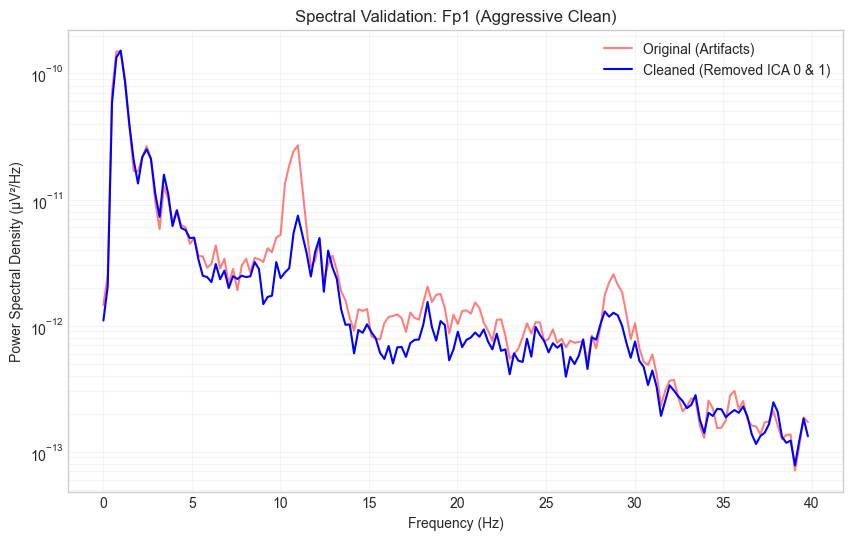

Plotting the removed components (ICA000 and ICA001)...


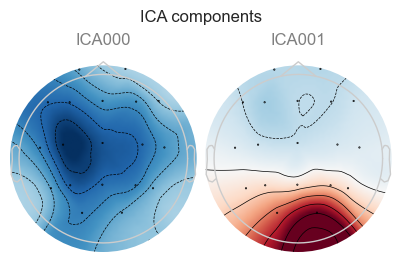

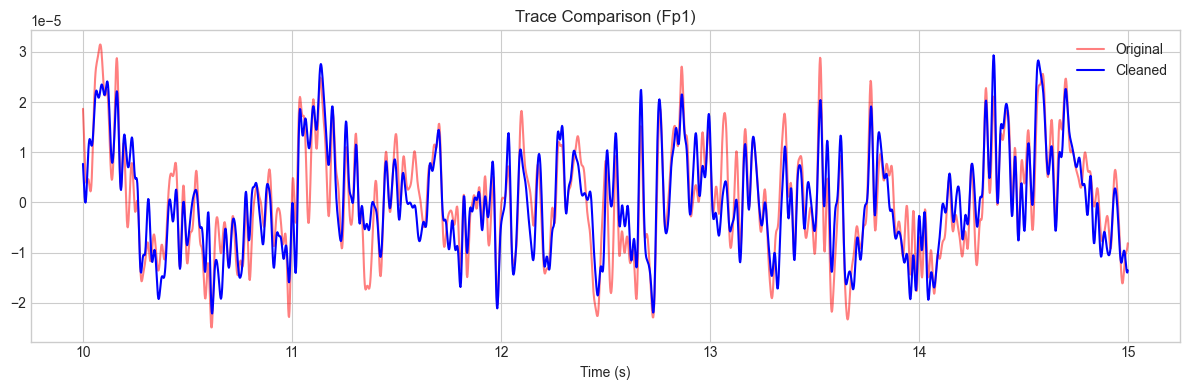

In [166]:
import mne
import numpy as np
import matplotlib.pyplot as plt

# --- CONFIGURATION ---
DATA_DIR = "eeg-during-mental-arithmetic-tasks-1.0.0"
FILE_PATH = f"{DATA_DIR}/Subject00_2.edf" 

def aggressive_ica_cleaning(filepath):
    print(f"Processing: {filepath}")
    
    # 1. Load & Setup
    raw = mne.io.read_raw_edf(filepath, preload=True, verbose=False)
    mne.rename_channels(raw.info, lambda x: x.replace('EEG ', ''))
    
    # 2. DROP BAD CHANNELS (Safety Step)
    raw.drop_channels(['ECG ECG', 'A2-A1'], on_missing='ignore')
    raw.set_montage('standard_1020', on_missing='ignore')
    
    # 3. Filter (High-pass 1.0 Hz)
    raw_filtered = raw.copy().filter(l_freq=1.0, h_freq=40.0, verbose=False)
    
    # 4. Fit ICA
    ica = mne.preprocessing.ICA(n_components=15, random_state=97, max_iter=800, verbose=False)
    ica.fit(raw_filtered)
    
    # 5. AGGRESSIVE SELECTION (The Fix)
    # We force removal of the first two components.
    # ICA000: Usually the Eye Blink or large slow drift.
    # ICA001: Usually the Saccade (eye movement) or secondary artifact.
    print("\n   > FORCE REMOVING: ICA000 & ICA001 (Top 2 noise sources)")
    ica.exclude = [0, 1]
    
    # 6. Apply Cleaning
    raw_clean = raw_filtered.copy()
    ica.apply(raw_clean, verbose=False)
    
    return raw_filtered, raw_clean, ica

# --- EXECUTION ---
raw_bad, raw_clean, ica = aggressive_ica_cleaning(FILE_PATH)

# --- VISUAL VERIFICATION ---

# 1. Spectral Comparison
# We expect the Blue line to FINALLY drop below the Red line in the 0-5Hz range.
psd_bad = raw_bad.compute_psd(picks=['Fp1'], fmax=40)
psd_clean = raw_clean.compute_psd(picks=['Fp1'], fmax=40)

data_bad = psd_bad.get_data(return_freqs=False)[0]
data_clean = psd_clean.get_data(return_freqs=False)[0]
freqs = psd_bad.freqs

plt.figure(figsize=(10, 6))
plt.semilogy(freqs, data_bad, color='red', alpha=0.5, label='Original (Artifacts)')
plt.semilogy(freqs, data_clean, color='blue', label='Cleaned (Removed ICA 0 & 1)')
plt.title("Spectral Validation: Fp1 (Aggressive Clean)")
plt.xlabel("Frequency (Hz)")
plt.ylabel("Power Spectral Density (µV²/Hz)")
plt.legend()
plt.grid(True, which='both', ls='-', alpha=0.2)
plt.show()

# 2. Inspect the Removed Components (Topomaps)
# We plot the "Faces" of the two components we just deleted.
# We expect at least one of them to be "Frontal" (red/blue at the eyes).
print("Plotting the removed components (ICA000 and ICA001)...")
ica.plot_components(picks=[0, 1])

# 3. Time Domain Check
# Zooming in on a noisy section to see the difference
start_t = 10 
duration = 5
segment_bad = raw_bad.get_data(picks='Fp1', tmin=start_t, tmax=start_t+duration)[0]
segment_clean = raw_clean.get_data(picks='Fp1', tmin=start_t, tmax=start_t+duration)[0]
times = np.linspace(start_t, start_t+duration, len(segment_bad))

plt.figure(figsize=(12, 4))
plt.plot(times, segment_bad, color='red', alpha=0.5, label='Original')
plt.plot(times, segment_clean, color='blue', label='Cleaned')
plt.title("Trace Comparison (Fp1)")
plt.xlabel("Time (s)")
plt.legend()
plt.tight_layout()
plt.show()

In [167]:
# --- METRIC RE-CALCULATION (Post-ICA) ---

def get_clean_band_power(raw, fmin, fmax):
    # Calculate PSD on the CLEANED data
    psd = raw.compute_psd(fmin=fmin, fmax=fmax, picks=['eeg'])
    # Get average power across all channels (or specific ROIs if preferred)
    data = psd.get_data(return_freqs=False)
    return np.mean(data)

# Define Bands
theta_band = (4, 8)
alpha_band = (8, 13)

# Calculate Powers
theta_power = get_clean_band_power(raw_clean, *theta_band)
alpha_power = get_clean_band_power(raw_clean, *alpha_band)

# Calculate New Ratio
ratio = theta_power / alpha_power

print(f"\n--- FINAL VALIDATED RESULTS ---")
print(f"Corrected Theta Power: {theta_power:.2e}")
print(f"Corrected Alpha Power: {alpha_power:.2e}")
print(f"Corrected Theta/Alpha Ratio: {ratio:.4f}")

# Optional: Frontal Asymmetry Check (Left vs Right Alpha)
# Higher Left Alpha = More Right Activity (Inverse relationship)
# We use F3 (Left) and F4 (Right)
if 'F3' in raw_clean.ch_names and 'F4' in raw_clean.ch_names:
    f3_power = get_clean_band_power(raw_clean.copy().pick(['F3']), *alpha_band)
    f4_power = get_clean_band_power(raw_clean.copy().pick(['F4']), *alpha_band)
    faa = np.log(f4_power) - np.log(f3_power)
    print(f"Frontal Alpha Asymmetry (FAA): {faa:.4f}")

Effective window size : 4.096 (s)
Effective window size : 4.096 (s)

--- FINAL VALIDATED RESULTS ---
Corrected Theta Power: 2.32e-12
Corrected Alpha Power: 4.27e-12
Corrected Theta/Alpha Ratio: 0.5428
Effective window size : 4.096 (s)
Effective window size : 4.096 (s)
Frontal Alpha Asymmetry (FAA): 0.3298
